# Image Classification

This notebook includes the code to load the Fashion-MNIST dataset using Keras, and a skeleton for the main sections that should be included in the notebook. Please see the assignment specification for more detail. You may wish to add extra subsections where appropriate. 

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from numpy.ma.core import expand_dims
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.utils import to_categorical
import keras_tuner as kt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## 1. Data loading, preprocessing, and exploration
We have included the code to load the dataset below. Please proceed with your data exploration and preprocessing steps, including creating any relevant data subsets required. The documentation for the data loading function can be accessed [here](https://keras.io/api/datasets/fashion_mnist/).

In [ ]:
# Load the Fashion-MNIST dataset training and test sets as numpy arrays
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [ ]:
# An ordered list of the class names
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"
              ]

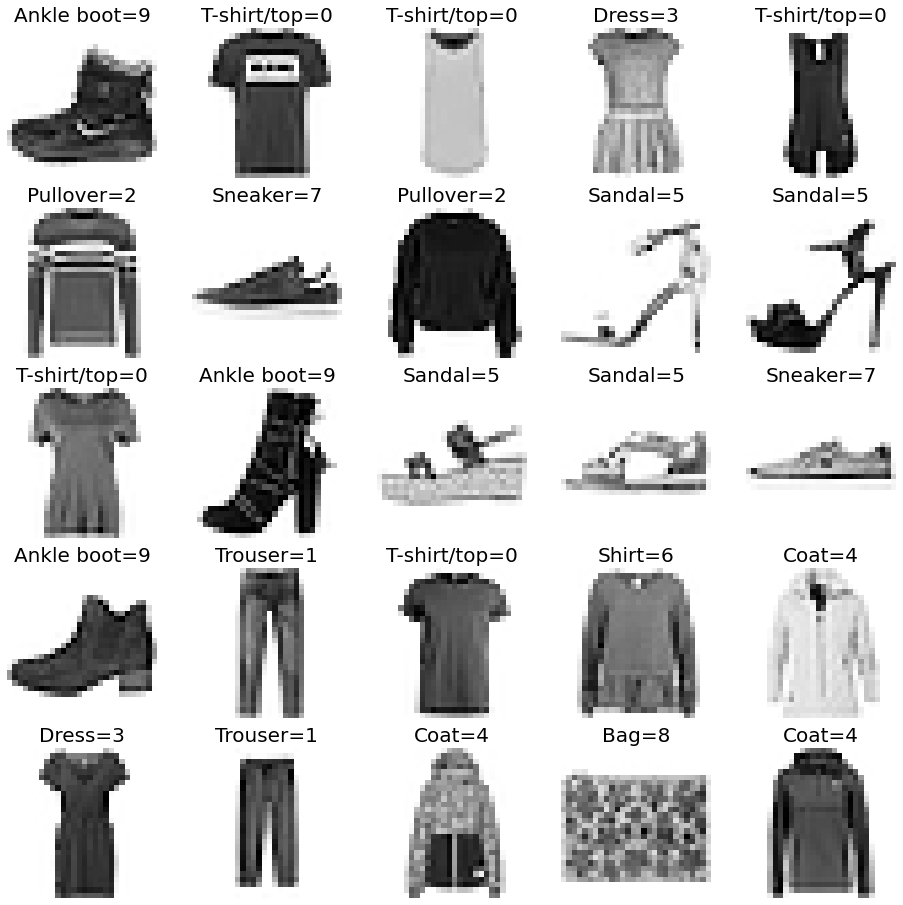

In [ ]:
# Looking at the data
plt.figure(figsize=(16,16))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(X_train[i], cmap="Greys")
  plt.axis('off')
  plt.title(class_names[y_train[i]]+"="+str(y_train[i]), fontsize=20)

In [ ]:
# Make backup
X_train_orig, X_test_orig = X_train, X_test
y_train_orig, y_test_orig = y_train, y_test

# Showing backup 
print('Origin Train: X=%s, y=%s' % (X_train_orig.shape, y_train_orig.shape))
print('Origin Test: X=%s, y=%s' % (X_test_orig.shape, y_test_orig.shape))

Origin Train: X=(60000, 28, 28), y=(60000,)
Origin Test: X=(10000, 28, 28), y=(10000,)


In [ ]:
# checkign dimension
X_train.ndim

3

In [ ]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Feature scaling
X_train = X_train/255
X_test = X_test/255

In [ ]:
# Validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.2, 
                                                  random_state = 0)
X_train.shape, y_train.shape

((48000, 28, 28, 1), (48000,))

In [114]:
# Validation datasets for 2d 
X_train_2d, X_valid_2d, y_train_2d, y_valid_2d = train_test_split(
X_train_orig, y_train_orig, train_size=0.9)

#converting 3d array to 2d array
X_2d_train = X_train_2d.reshape(54000,28*28)
X_2d_valid = X_valid_2d.reshape(6000,28*28)

# summarize validation sets
print('Valididation set -  Train: X=%s, y=%s' % (X_train_2d.shape, 
                                                 y_train_2d.shape))
print('Validation set - Test: X=%s, y=%s' % (X_valid_2d.shape, 
                                             y_valid_2d.shape))

Valididation set -  Train: X=(54000, 28, 28), y=(54000,)
Validation set - Test: X=(6000, 28, 28), y=(6000,)


## 2. Algorithm design and setup

### KNN

In [119]:
# KNN classification 
knn = KNeighborsClassifier(n_neighbors=10)
knn_history = knn.fit(X_2d_train, y_train_2d)
y_pred = knn.predict(X_2d_valid)
print("Accuracy on test set: {:.4f}".format(accuracy_score(y_valid_2d, y_pred)))

Accuracy on test set: 0.8507


### Fully connected neural network

In [ ]:
model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='tanh'),
    keras.layers.Dense(100, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')
])

model_mlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 300)               235500    
                                                                 
 dense_9 (Dense)             (None, 100)               30100     
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_mlp.compile(loss='sparse_categorical_crossentropy', 
                  optimizer = 'sgd', 
                  metrics=['accuracy'])

In [ ]:
history_mlp = model_mlp.fit(X_train, y_train, 
                            epochs=5, 
                            validation_data=(X_val, y_val))

Epoch 1/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.6772 - accuracy: 0.7762 - val_loss: 0.5081 - val_accuracy: 0.8261
Epoch 2/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4777 - accuracy: 0.8314 - val_loss: 0.4492 - val_accuracy: 0.8423
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4371 - accuracy: 0.8444 - val_loss: 0.4301 - val_accuracy: 0.8478
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4141 - accuracy: 0.8526 - val_loss: 0.4293 - val_accuracy: 0.8409
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3982 - accuracy: 0.8577 - val_loss: 0.4055 - val_accuracy: 0.8544


In [ ]:
# Testing the model
y_pred_mlp = model_mlp.predict(X_test).round(2)

313/313 [==============================] - 1s 2ms/step


In [ ]:
model_mlp.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4336 - accuracy: 0.8416


[0.4335722029209137, 0.8416000008583069]

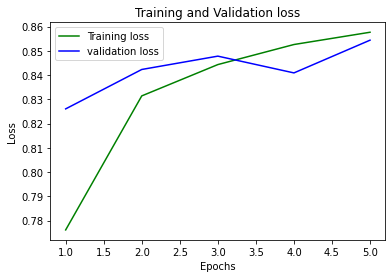

In [ ]:
loss_train = history_mlp.history['accuracy']
loss_val = history_mlp.history['val_accuracy']
epochs = [1,2,3,4,5]
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

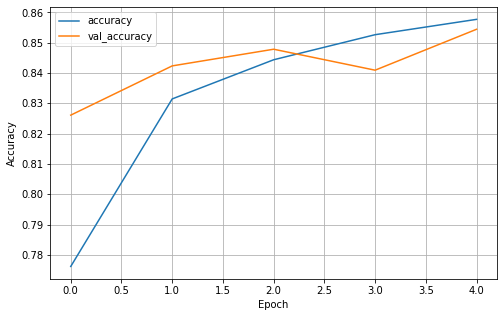

In [ ]:
accuracies = pd.DataFrame(history_mlp.history)[['accuracy', 'val_accuracy']]
# Plot the accuracies
accuracies.plot(figsize=(8, 5)) 
plt.grid(True) 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

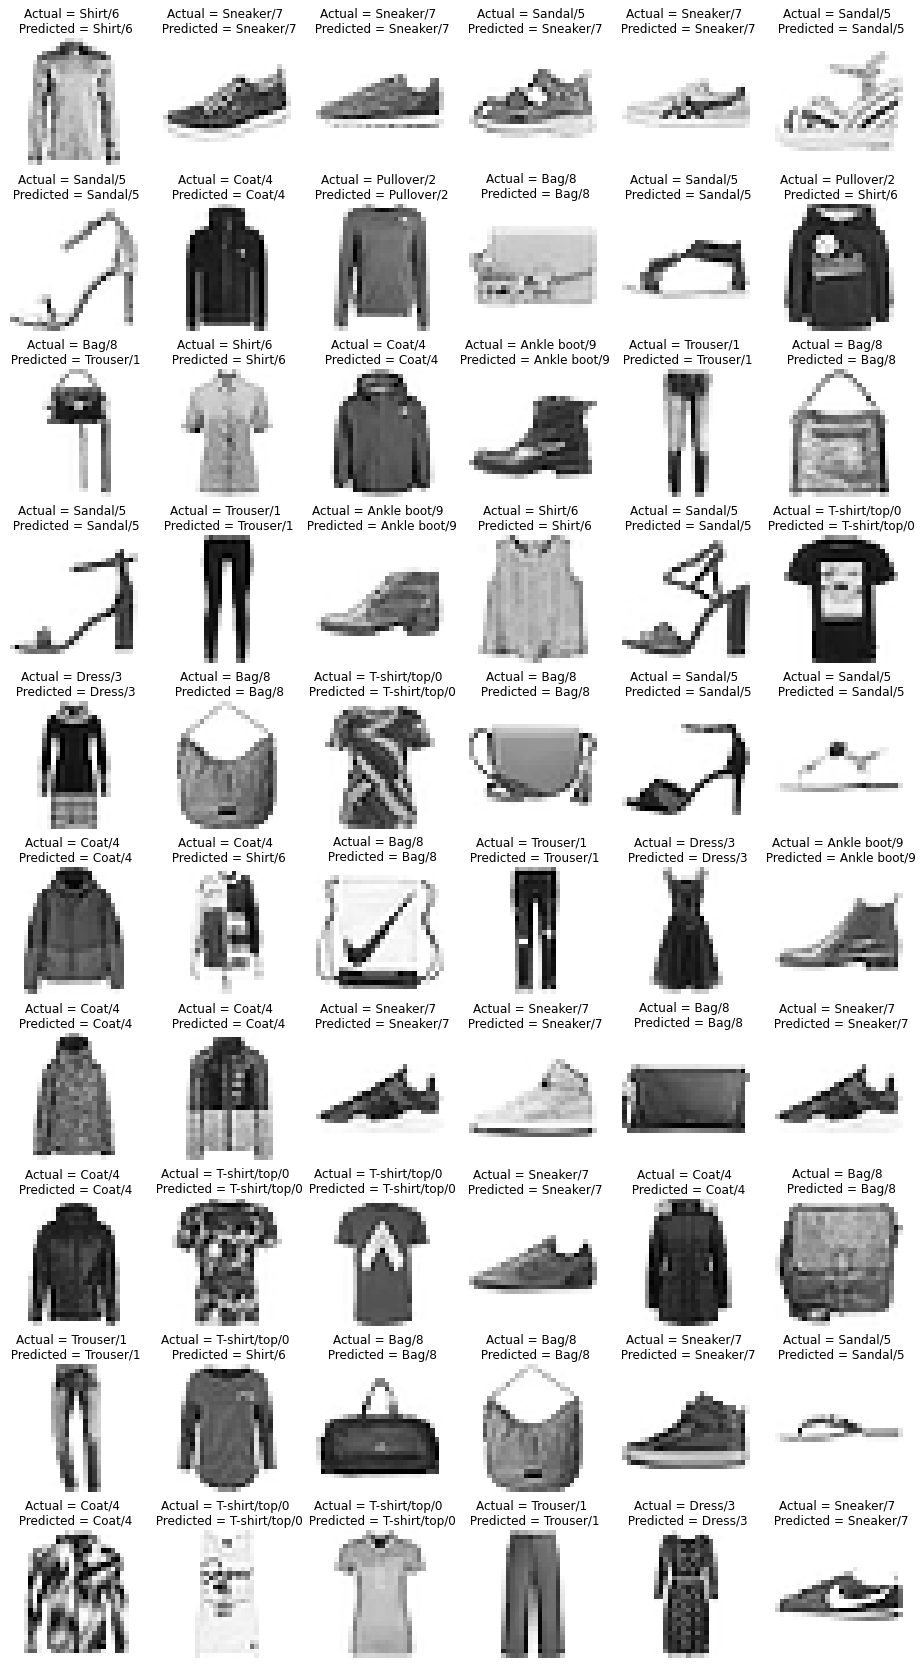

In [ ]:
# Looking at predictions
plt.figure(figsize=(16,30))
j=1
for i in np.random.randint(0, 1000, 60):
  plt.subplot(10, 6, j); j+=1
  plt.imshow(X_test[i].reshape(28,28), cmap="Greys")
  plt.axis('off')
  plt.title(
      'Actual = {}/{} \n Predicted = {}/{}'.format(
          class_names[y_test[i]], 
          y_test[i], 
          class_names[np.argmax(y_pred_mlp[i])], 
          np.argmax(y_pred_mlp[i])
          )
      )

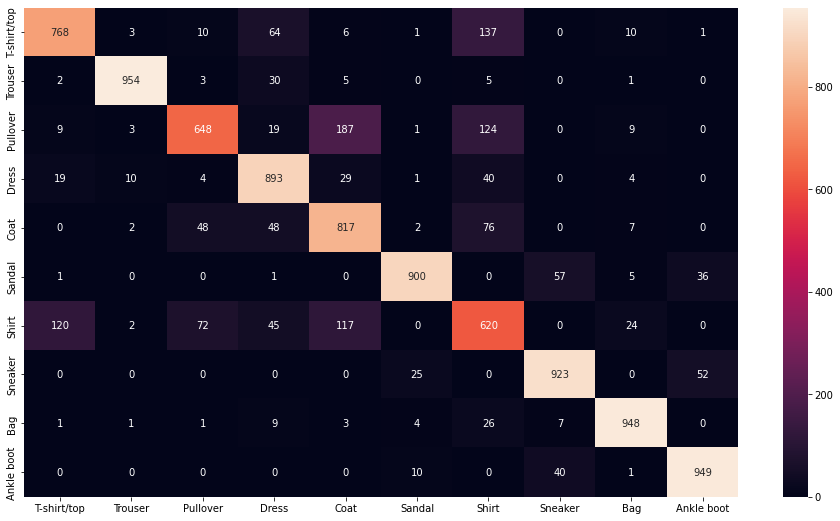

In [ ]:
plt.figure(figsize=(16,9))
y_pred_labels_mlp = [np.argmax(label) for label in y_pred_mlp]
cm_mlp = confusion_matrix(y_test, y_pred_labels_mlp)

sns.heatmap(cm_mlp, annot=True, fmt='d', 
            xticklabels = class_names, yticklabels = class_names)

In [ ]:
cr_mlp = classification_report(y_test, 
                               y_pred_labels_mlp, 
                               target_names = class_names)
print(cr_mlp)

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.77      0.80      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.82      0.65      0.73      1000
       Dress       0.81      0.89      0.85      1000
        Coat       0.70      0.82      0.76      1000
      Sandal       0.95      0.90      0.93      1000
       Shirt       0.60      0.62      0.61      1000
     Sneaker       0.90      0.92      0.91      1000
         Bag       0.94      0.95      0.94      1000
  Ankle boot       0.91      0.95      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



### Convolutional neural network

In [ ]:
# CNN
model_cnn = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), 
                        padding='valid', activation = 'relu', 
                        input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), 
                        padding='valid', activation = 'relu', 
                        input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(), 
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=128, activation='relu'), 
    keras.layers.Dense(units=10, activation='softmax')
])
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)             

In [ ]:
model_cnn.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
history_cnn = model_cnn.fit(X_train, y_train, epochs=5, batch_size = 512, 
                            verbose = 1, validation_data = (X_val, y_val))

Epoch 1/5
94/94 [==============================] - 28s 295ms/step - loss: 0.8313 - accuracy: 0.7095 - val_loss: 0.5010 - val_accuracy: 0.8176
Epoch 2/5
94/94 [==============================] - 26s 275ms/step - loss: 0.4687 - accuracy: 0.8296 - val_loss: 0.4124 - val_accuracy: 0.8549
Epoch 3/5
94/94 [==============================] - 25s 263ms/step - loss: 0.4130 - accuracy: 0.8487 - val_loss: 0.3697 - val_accuracy: 0.8713
Epoch 4/5
94/94 [==============================] - 26s 275ms/step - loss: 0.3767 - accuracy: 0.8646 - val_loss: 0.3494 - val_accuracy: 0.8802
Epoch 5/5
94/94 [==============================] - 25s 263ms/step - loss: 0.3533 - accuracy: 0.8719 - val_loss: 0.3447 - val_accuracy: 0.8771


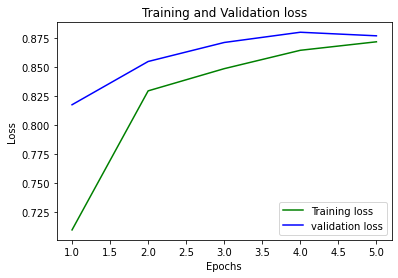

In [ ]:
loss_train = history_cnn.history['accuracy']
loss_val = history_cnn.history['val_accuracy']
epochs = [1,2,3,4,5]
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

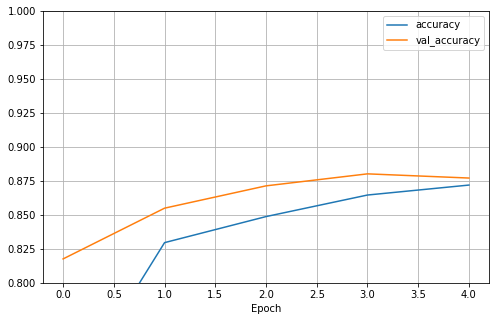

In [ ]:
accuracies = pd.DataFrame(history_cnn.history)[['accuracy', 'val_accuracy']]
# Plot the accuracies
accuracies.plot(figsize=(8, 5)) 
plt.grid(True) 
plt.gca().set_ylim(0.8, 1) 
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Testing the model
y_pred_cnn = model_cnn.predict(X_test).round(2)

313/313 [==============================] - 2s 7ms/step


In [ ]:
model_cnn.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.3574 - accuracy: 0.8717


[0.3574245572090149, 0.8716999888420105]

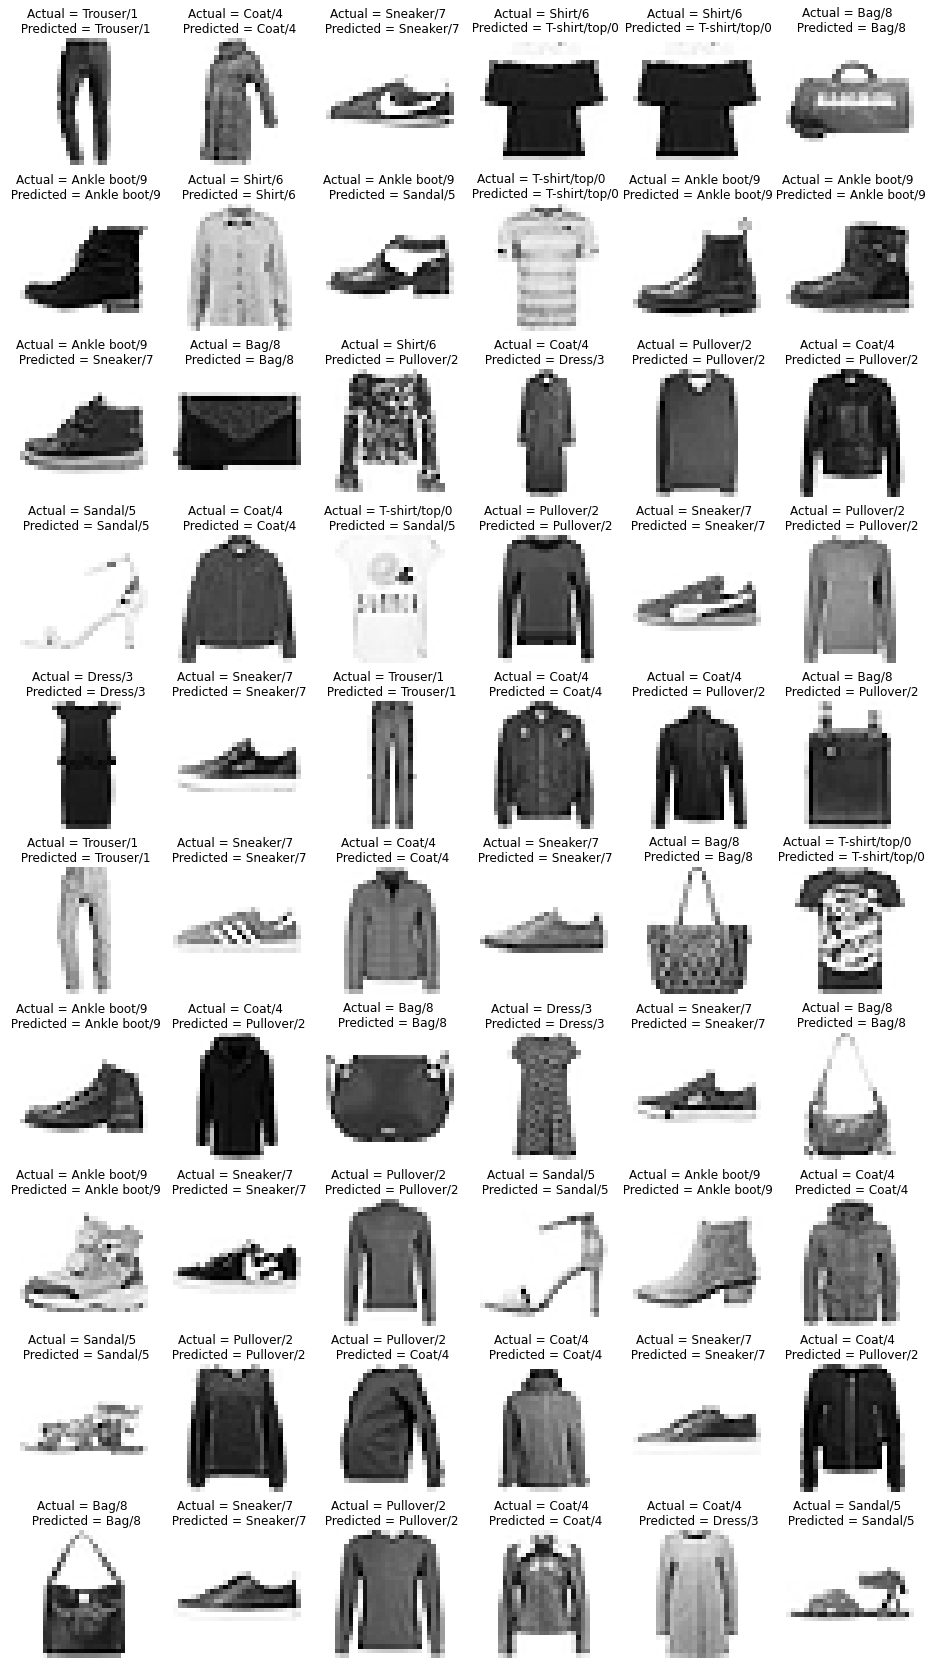

In [ ]:
# Looking at the data
plt.figure(figsize=(16,30))
j=1
for i in np.random.randint(0, 1000, 60):
  plt.subplot(10, 6, j); j+=1
  plt.imshow(X_test[i].reshape(28,28), cmap="Greys")
  plt.axis('off')
  plt.title('Actual = {}/{} \n Predicted = {}/{}'.format(
      class_names[y_test[i]], 
      y_test[i], 
      class_names[np.argmax(y_pred_cnn[i])], 
      np.argmax(y_pred_cnn[i])
      )
  )

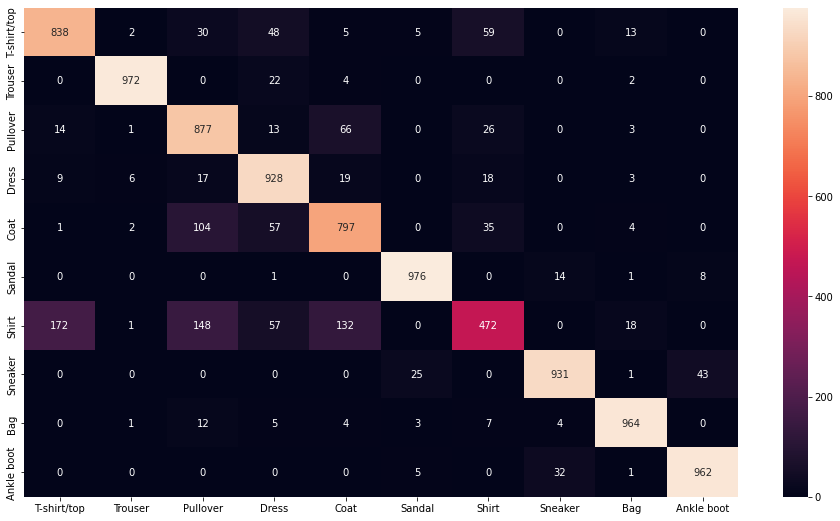

In [ ]:
plt.figure(figsize=(16,9))
y_pred_labels_cnn = [np.argmax(label) for label in y_pred_cnn]
cm_cnn = confusion_matrix(y_test, y_pred_labels_cnn)

sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels = class_names, yticklabels = class_names)

In [ ]:
cr_cnn = classification_report(y_test, y_pred_labels_cnn, target_names = class_names)
print(cr_cnn)

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.84      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.74      0.88      0.80      1000
       Dress       0.82      0.93      0.87      1000
        Coat       0.78      0.80      0.79      1000
      Sandal       0.96      0.98      0.97      1000
       Shirt       0.76      0.47      0.58      1000
     Sneaker       0.95      0.93      0.94      1000
         Bag       0.95      0.96      0.96      1000
  Ankle boot       0.95      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [ ]:
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', 
                    return_train_score=False,verbose=1)

In [ ]:
# fitting the model for grid search
grid_search = grid.fit(X_2d_train, y_train_2d)

# print best parameter after tuning
tmp_best_para = grid.best_params_
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(X_2d_valid)
  
# print classification report
print(classification_report(y_valid_2d, grid_predictions))

### Fully connected neural network

In [ ]:
def build_mlp(
    n_hidden_layers=4, n_hidden_neurons=200,
    activation_function="relu", input_shape=[28,28]
    ):
  model = keras.models.Sequential()
  # Add the input layer
  model.add(keras.layers.Flatten(input_shape=input_shape))
  # Add the hidden layers with desired size and activation function
  for layer in range(n_hidden_layers):
    model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
    # Add the output layer for 10 class classification
  model.add(keras.layers.Dense(10, activation="softmax")) 
  return model

In [ ]:
! pip install scikeras
from scikeras.wrappers import KerasClassifier
# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them 
keras_classifier = KerasClassifier(build_mlp,
                                   n_hidden_layers=4,
                                   n_hidden_neurons=200,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__lr=0.1,
                                   metrics=["accuracy"]
                                   )

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_hidden_neurons": [200, 250, 300],
    "optimizer__lr": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh"],
    'batch_size':[100, 200, 300],
    'epochs':[5, 6],
    'n_hidden_layers': [2,3,5],
    'optimizer': ['Adam', 'SGD' ]
}

grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search_cv.fit(X_train[0:1000], y_train[0:1000])

In [ ]:
grid_search_cv.best_params_, grid_search_cv.best_score_

### Convolutional neural network

In [133]:
def build_model_cnn(hp):
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), # filters
        kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), # filter size
        activation=hp.Choice("activation", ["relu", "tanh"]),
        input_shape=(28,28,1)
    ),
    # keras.layers.Conv2D(
    #     filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16), # filters
    #     kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), # filter size
    #     activation=hp.Choice("activation", ["relu", "tanh"]),
    #     input_shape=(28,28,1)
    # ),
    keras.layers.Dense(128, 
                       activation=hp.Choice("activation", ["relu", "tanh"])),
    keras.layers.Flatten(),
  ])
  if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(rate=0.25))  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [134]:
tuner_search = RandomSearch(build_model_cnn, objective='val_loss', max_trials=10)

In [ ]:
tuner_search.search(X_train,y_train,epochs=5, validation_data=(X_val, y_val))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |?                 |conv_1_filter
3                 |?                 |conv_1_kernel
tanh              |?                 |activation
64                |?                 |conv_2_filter
False             |?                 |dropout
0.01              |?                 |learning_rate

Epoch 1/5
1500/1500 [==============================] - 120s 79ms/step - loss: 11.3989 - accuracy: 1.8750e-04 - val_loss: 11.3682 - val_accuracy: 0.0000e+00
Epoch 2/5
 261/1500 [====>.........................] - ETA: 1:38 - loss: 11.3682 - accuracy: 0.0000e+00

In [ ]:
model = tuner_search.get_best_models(num_models=1)[0]
model.summary()

In [ ]:
tuner_search.search_space_summary()

In [ ]:
tuner_search.results_summary()

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [ ]:
# Check the format of the label by looking at the first five examples
print(y_train_2d[0:5])

# List all unique labels in the training set
print(np.unique(y_train_2d))

In [123]:
# KNN
best_k = 4
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_2d_train, y_train_2d)
y_pred = knn_best.predict(X_2d_valid)
print("Accuracy on test set: {:.4f}".format(accuracy_score(y_valid_2d, y_pred)))

Accuracy on test set: 0.8535


### Fully connected neural network

In [ ]:
tuned_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(200, activation='sigmoid', batch_size = 200),
    keras.layers.Dense(200, activation='sigmoid', batch_size = 200),
    keras.layers.Dense(10, activation='softmax')
])
tuned_mlp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 200)               157000    
                                                                 
 dense_14 (Dense)            (None, 200)               40200     
                                                                 
 dense_15 (Dense)            (None, 10)                2010      
                                                                 
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuned_mlp.compile(loss='sparse_categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [ ]:
history_tuned_mlp = tuned_mlp.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
1500/1500 [==============================] - 6s 3ms/step - loss: 0.5836 - accuracy: 0.7912 - val_loss: 0.4185 - val_accuracy: 0.8508
Epoch 2/5
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3968 - accuracy: 0.8551 - val_loss: 0.3904 - val_accuracy: 0.8556
Epoch 3/5
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3565 - accuracy: 0.8692 - val_loss: 0.3512 - val_accuracy: 0.8718
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3289 - accuracy: 0.8801 - val_loss: 0.3534 - val_accuracy: 0.8692
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3105 - accuracy: 0.8860 - val_loss: 0.3286 - val_accuracy: 0.8802


In [ ]:
y_pred_tuned_mlp = tuned_mlp.predict(X_test).round(2)

313/313 [==============================] - 1s 2ms/step


In [ ]:
tuned_mlp.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3585 - accuracy: 0.8677


[0.35850971937179565, 0.8676999807357788]

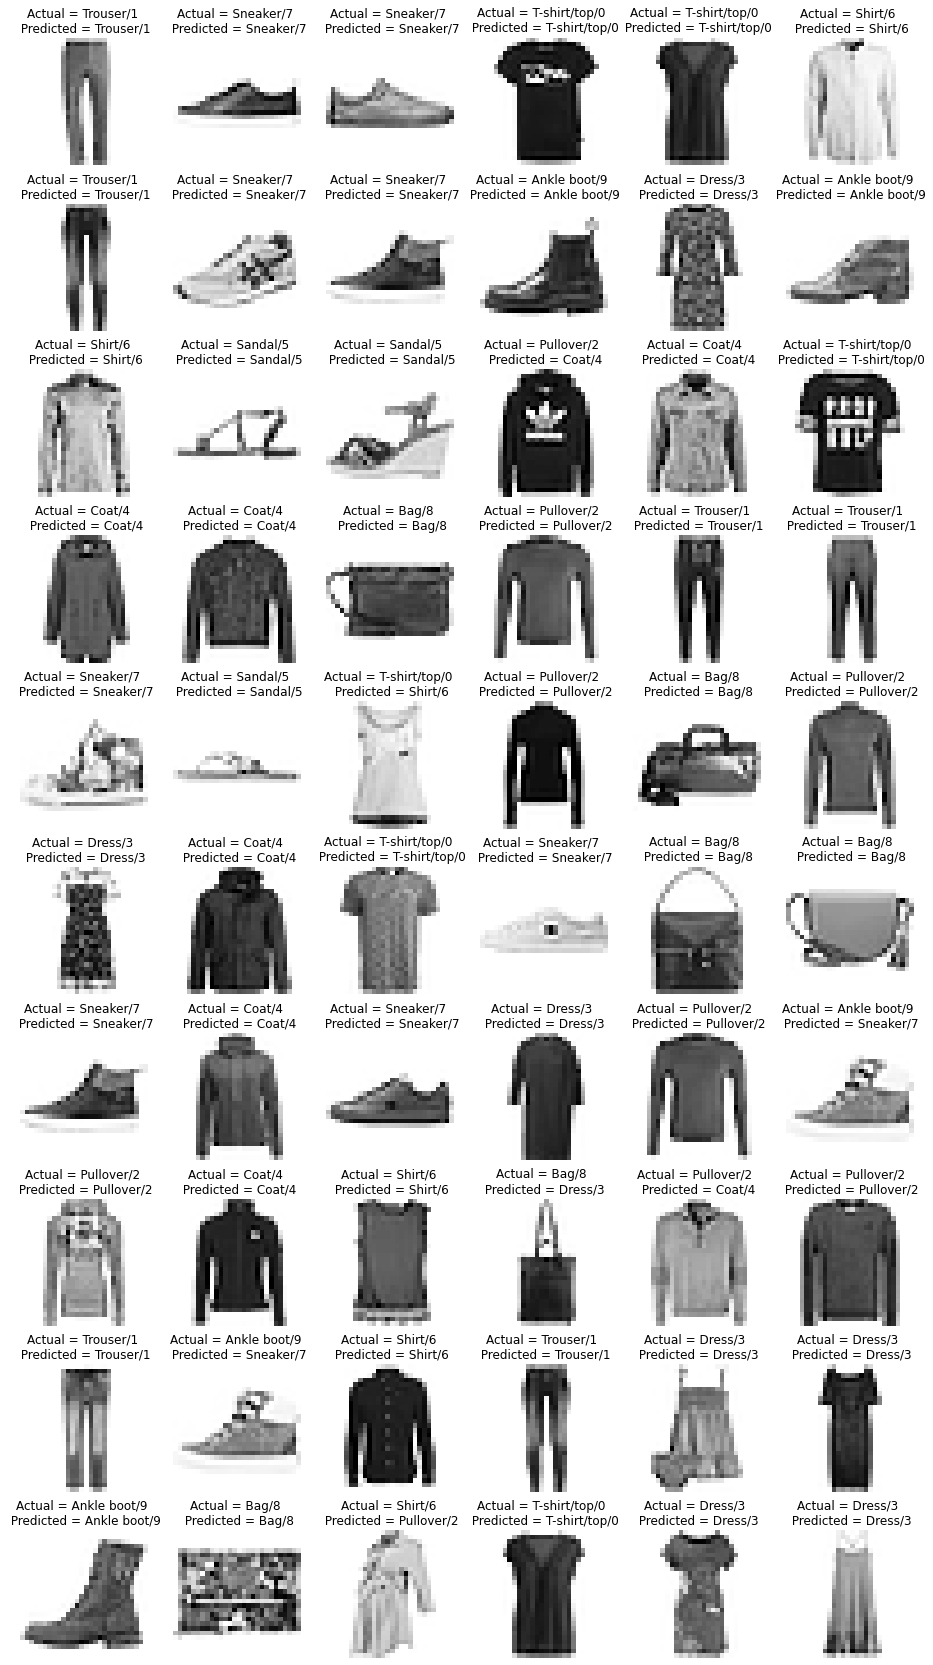

In [ ]:
# Looking at the data
plt.figure(figsize=(16,30))
j=1
for i in np.random.randint(0, 1000, 60):
  plt.subplot(10, 6, j); j+=1
  plt.imshow(X_test[i].reshape(28,28), cmap="Greys")
  plt.axis('off')
  plt.title('Actual = {}/{} \n Predicted = {}/{}'.format(
      class_names[y_test[i]], 
      y_test[i], 
      class_names[np.argmax(y_pred_tuned_mlp[i])], 
      np.argmax(y_pred_tuned_mlp[i])))

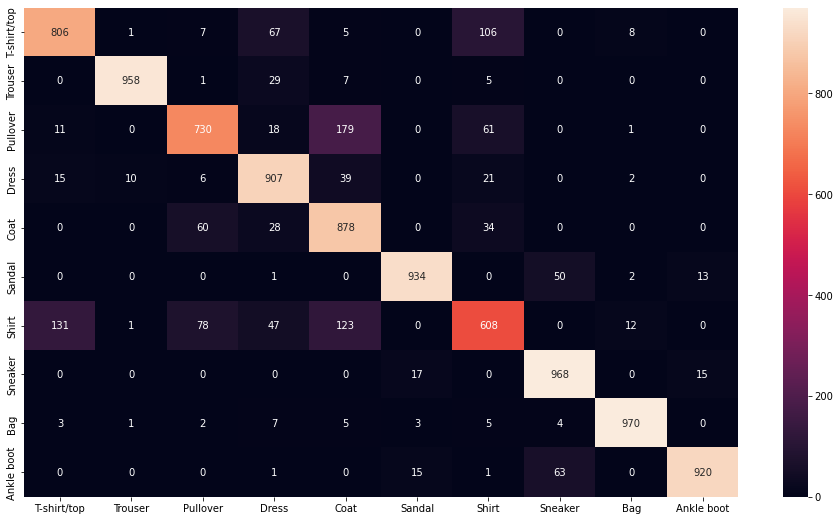

In [ ]:
plt.figure(figsize=(16,9))
y_pred_tuned_mlp_labels = [np.argmax(label) for label in y_pred_tuned_mlp]
cm_cnn = confusion_matrix(y_test, y_pred_tuned_mlp_labels)

sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels = class_names, yticklabels = class_names)

In [ ]:
cr_tuned_mlp = classification_report(y_test, y_pred_tuned_mlp_labels, target_names = class_names)
print(cr_tuned_mlp)

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.81      0.82      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.83      0.73      0.77      1000
       Dress       0.82      0.91      0.86      1000
        Coat       0.71      0.88      0.79      1000
      Sandal       0.96      0.93      0.95      1000
       Shirt       0.72      0.61      0.66      1000
     Sneaker       0.89      0.97      0.93      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.92      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### Convolutional neural network

In [126]:
model_cnn_tuned = keras.models.Sequential([
    keras.layers.Conv2D(filters=54, kernel_size=5, strides=(1,1), 
                        padding='valid', activation = 'tanh', 
                        input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Flatten(), 
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=128, activation='relu'), 
    keras.layers.Dense(units=10, activation='softmax')
])
model_cnn_tuned.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 24, 24, 54)        1404      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 12, 12, 54)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 7776)              0         
                                                                 
 dropout_18 (Dropout)        (None, 7776)              0         
                                                                 
 dense_26 (Dense)            (None, 128)               995456    
                                                                 
 dense_27 (Dense)            (None, 10)                1290      
                                                     

In [127]:
model_cnn_tuned.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_tuned_chh = model_cnn_tuned.fit(X_train, y_train, epochs=5, validation_data = (X_val, y_val))

Epoch 1/5
1500/1500 [==============================] - 47s 31ms/step - loss: 0.4313 - accuracy: 0.8443 - val_loss: 0.3304 - val_accuracy: 0.8813
Epoch 2/5
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2957 - accuracy: 0.8920 - val_loss: 0.2932 - val_accuracy: 0.8950
Epoch 3/5
1500/1500 [==============================] - 39s 26ms/step - loss: 0.2425 - accuracy: 0.9097 - val_loss: 0.2844 - val_accuracy: 0.8994
Epoch 4/5
1500/1500 [==============================] - 40s 27ms/step - loss: 0.2071 - accuracy: 0.9230 - val_loss: 0.2752 - val_accuracy: 0.9028
Epoch 5/5
1500/1500 [==============================] - 38s 26ms/step - loss: 0.1814 - accuracy: 0.9308 - val_loss: 0.2780 - val_accuracy: 0.9055


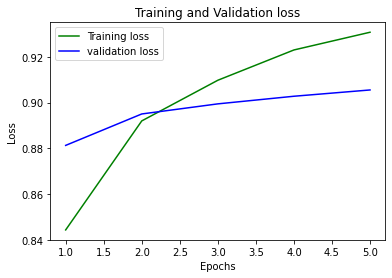

In [128]:
loss_train = history_tuned_chh.history['accuracy']
loss_val = history_tuned_chh.history['val_accuracy']
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

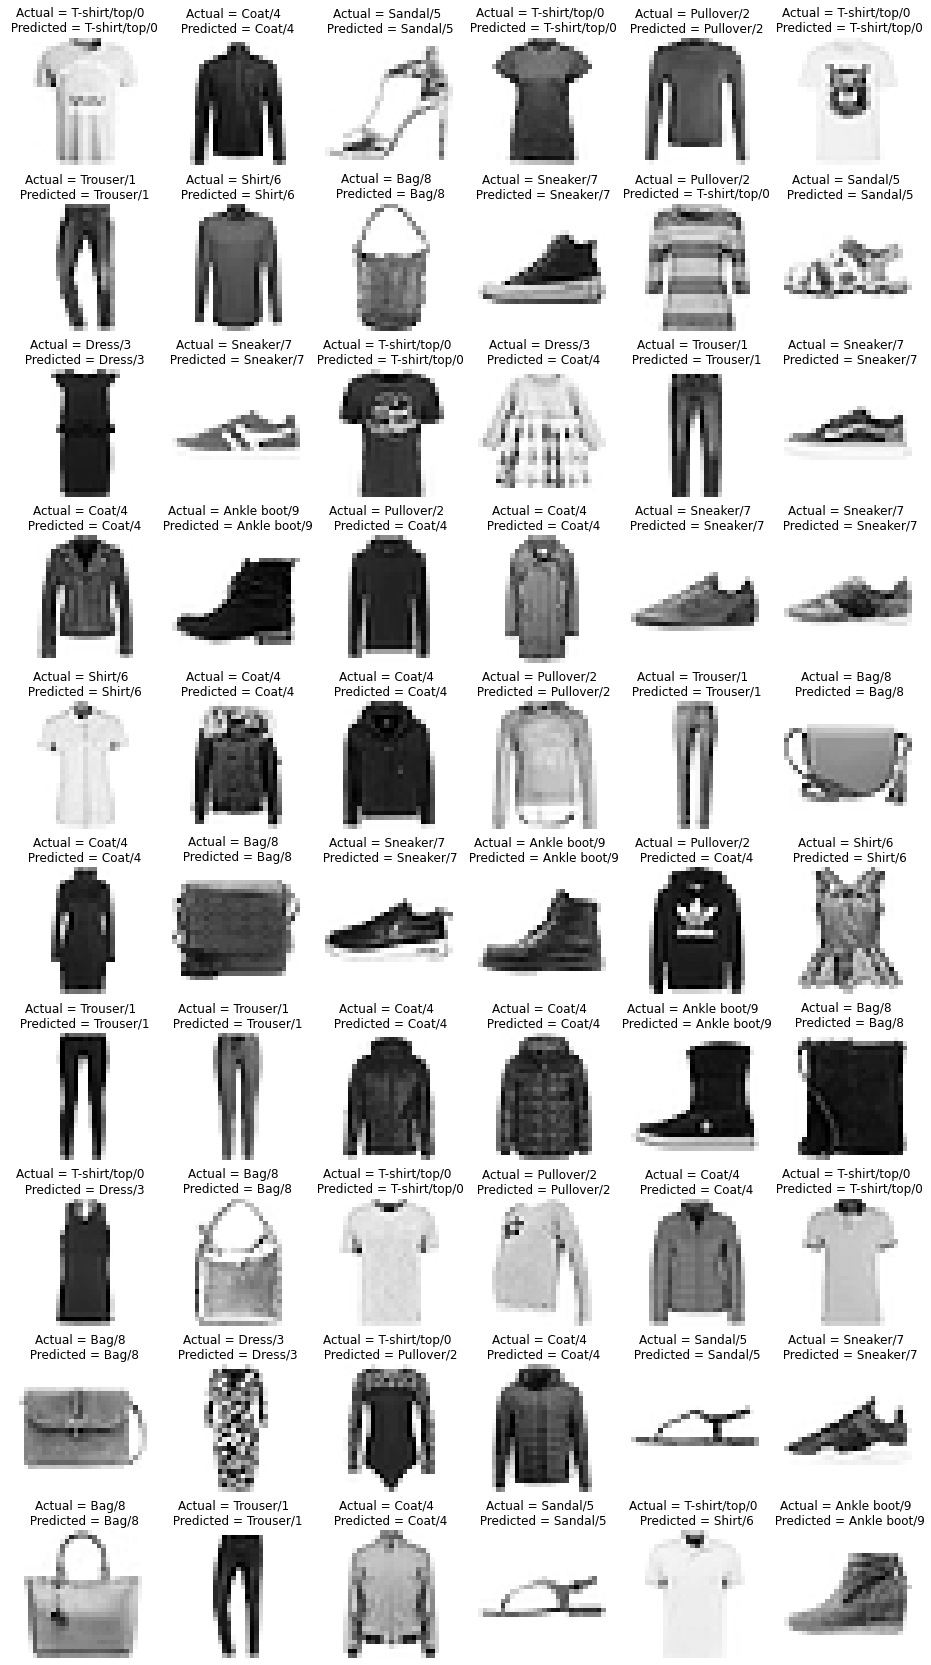

In [129]:
# Looking at the data
plt.figure(figsize=(16,30))
j=1
for i in np.random.randint(0, 1000, 60):
  plt.subplot(10, 6, j); j+=1
  plt.imshow(X_test[i].reshape(28,28), cmap="Greys")
  plt.axis('off')
  plt.title('Actual = {}/{} \n Predicted = {}/{}'.format(
      class_names[y_test[i]], 
      y_test[i], 
      class_names[np.argmax(y_pred_tuned_mlp[i])], 
      np.argmax(y_pred_tuned_mlp[i])))